In [9]:
from IPython.display import Image


## Purpose :
#### Predict NYC Taxi trip duration in `RMSLE` metric ( Root Mean Squared Logarithmic Error) 

- https://www.kaggle.com/c/nyc-taxi-trip-duration#evaluation



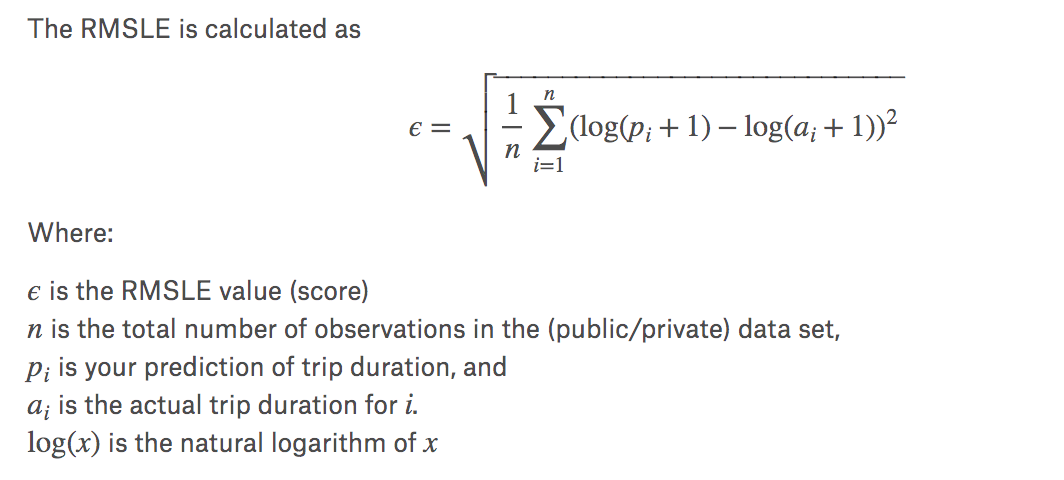

In [17]:
Image(filename='../NYC_Taxi_Trip_Duration/documents/RMSLE.png') 


## Process : 
    - 0 Feature engineering 
    - 1 Simple modeling 
    - 2 SELECT MODELS 
        -2.1 parameter select 
        -2.2 model tuning
    - 3 PREDICTION ENSEMBLE 

In [8]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt
from IPython.display import Image 

Populating the interactive namespace from numpy and matplotlib


In [13]:
# load data

df_train = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/train.csv')
df_test = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/test.csv')
sampleSubmission = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/sample_submission.csv')

In [4]:
# basic feature extract 

def basic_feature_extract(df):
    df_= df.copy()
    # pickup
    df_["pickup_date"] = pd.to_datetime(df_.pickup_datetime.apply(lambda x : x.split(" ")[0]))
    df_["pickup_hour"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["pickup_year"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["pickup_month"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["pickup_weekday"] = df_.pickup_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    # dropoff 
    df_["dropoff_date"] = pd.to_datetime(df_.dropoff_datetime.apply(lambda x : x.split(" ")[0]))
    df_["dropoff_hour"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["dropoff_year"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["dropoff_month"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["dropoff_weekday"] = df_.dropoff_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    return df_


# get weekday
import calendar
def get_weekday(df):
    list(calendar.day_name)
    df_=df.copy()
    df_['pickup_week_'] = pd.to_datetime(df_train.pickup_datetime,coerce=True).dt.weekday
    df_['pickup_weekday_'] = df_['pickup_week_'].apply(lambda x: calendar.day_name[x])
    return df_

# get trip duration 
def get_duration(df):
    df_= df.copy()
    df_['trip_duration_cal'] = pd.to_datetime(df_['dropoff_datetime']) - pd.to_datetime(df_['pickup_datetime'])
    return df_
    



In [5]:
df_train_ = basic_feature_extract(df_train)

In [6]:
df_train_ = get_duration(df_train_)

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:26: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


In [19]:
df_train_ = get_weekday(df_train_)

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:26: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


In [20]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,pickup_weekday,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,03,0,2016-03-14,17,2016,03,0,00:07:35,0,Monday


## 0) Feature engineering 

In [78]:
# feature extract


###  distance 
# https://www.kaggle.com/gaborfodor/from-eda-to-submission-lb-0-380


# Haversine distance
# common distance method in geopy

def get_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h 

# Manhattan distance
# Taxi cant fly ! have to move in blocks/roads

def get_manhattan_distance(lat1, lng1, lat2, lng2):
    a = get_haversine_distance(lat1, lng1, lat1, lng2)
    b = get_haversine_distance(lat1, lng1, lat2, lng1)
    return a + b


## model evaluate 
def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [79]:
###  USING .loc making return array ordering 

# get haversine distance 
df_train_.loc[:, 'distance_haversine'] = get_haversine_distance(
                      df_train_['pickup_latitude'].values,
                      df_train_['pickup_longitude'].values,
                      df_train_['dropoff_latitude'].values,
                      df_train_['dropoff_longitude'].values)

# get manhattan distance 

df_train_.loc[:, 'distance_manhattan'] = get_manhattan_distance(
                      df_train_['pickup_latitude'].values,
                      df_train_['pickup_longitude'].values,
                      df_train_['dropoff_latitude'].values,
                      df_train_['dropoff_longitude'].values)


In [84]:
#df_train_[['pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude','distance_manhattan']]

df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_,distance_haversine,distance_manhattan
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,2016-03-14,17,2016,03,0,00:07:35,0,Monday,1.498521,1.735433
